In [1]:
%matplotlib notebook
from pyfeti.src.utils import DomainCreator, dict2dfmap, create_selection_operator, DofManager
from pyfeti.src.feti_solver import SerialFETIsolver, SolverManager
from pyfeti.cases.case_generator import FETIcase_builder
from scipy import sparse
import amfe
import numpy as np
import matplotlib.pyplot as plt
import copy


def arnoldi_iteration(A,b,nimp):
    """
    Input
    A: (nxn matrix)
    b: (initial vector)
    k: number of iterations
    
    Returns Q, h
    
    """
    m = A.shape[0] # Shape of the input matrix

    h = np.zeros((nimp+1, nimp))    # Creates a zero matrix of shape (n+1)x n
    Q = np.zeros((m, nimp+1))       # Creates a zero matrix of shape m x n

    q  = b/np.linalg.norm(b)        # Normalize the input vector
    q = np.reshape(q,(1,m))
    Q[:, 0] = q[0]                     # Adds q to the first column of Q
    
    for n in range(nimp):           
        v = A.dot(q.flatten())                # A*q_0
        for j in range(n+1):
            h[j, n] = float(v.dot(Q[:,j]))
            v = v - h[j,n]*Q[:,j]   

        h[n+1, n] = np.linalg.norm(v)
        q = v / h[n+1, n]
        Q[:, n+1] = q
    return Q[:,:nimp], h[:nimp,:nimp]


Could not load paradiso!
Could not load paradiso!
Warning! Using python in global path


<IPython.core.display.Javascript object>


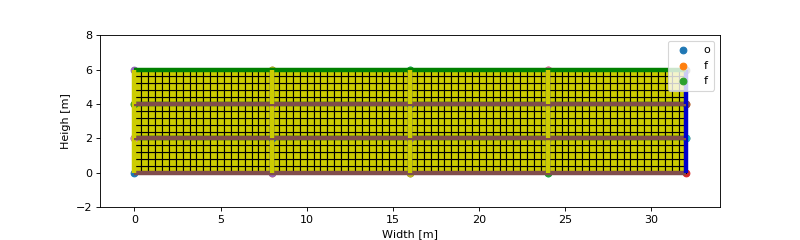

In [2]:
width = 8.
heigh = 2.
divX=21
divY=6
dobj = DomainCreator(width=width,heigh=heigh,x_divisions=divX,y_divisions=divY)
mesh_file = 'mesh.msh'
dobj.save_gmsh_file(mesh_file)

m1 = amfe.Mesh()
m1.import_msh(mesh_file)


domains_X = 4
domains_Y = 3
base = np.array([1,1,1])
scale_list = 0.5*np.ones(domains_X*domains_Y) + 0.5*np.random.rand(domains_X*domains_Y)
mesh_list = []
facecolor_list = []
scale = 1
count=0
for my in range(domains_Y):
    for mx in range(domains_X):
        mij = m1.translation(np.array([mx*width,my*heigh]))
        mesh_list.append(mij) 
        facecolor_list.append(scale_list[count]*base)
        count+=1
#mesh_list = [m1,m2]

fig1, ax1 = plt.subplots(1,1,figsize=(10,3))

for mi in mesh_list :
    amfe.plot2Dmesh(mi,ax=ax1)

ax1.set_xlim([-2,domains_X*width+2])
ax1.set_ylim([-2,domains_Y*heigh+2])
ax1.set_aspect('equal')
ax1.set_xlabel('Width [m]')
ax1.set_ylabel('Heigh [m]')
plt.legend('off')

# Solving Static Problem

$$
\begin{bmatrix}
\mathbf{K} & \mathbf{B^T}  \\
\mathbf{B} & \mathbf{0}  
\end{bmatrix}
\begin{bmatrix}
\mathbf{u}  \\
\mathbf{\lambda}   
\end{bmatrix}
=
\begin{bmatrix}
\mathbf{f}  \\
\mathbf{0}   
\end{bmatrix}
$$

In [3]:
# creating material
my_material = amfe.KirchhoffMaterial(E=210.0E9, nu=0.3, rho=7.86E3, plane_stress=True, thickness=1.0)

my_system1 = amfe.MechanicalSystem()
my_system1.set_mesh_obj(m1)
my_system1.set_domain(3,my_material)

K1, _ = my_system1.assembly_class.assemble_k_and_f()
M1 = my_system1.assembly_class.assemble_m()


system_list = []
for mi in mesh_list:
    sysi = amfe.MechanicalSystem()
    sysi.set_mesh_obj(mi)
    sysi.set_domain(3,my_material)
    system_list.append(sysi)
#K2, _ = my_system2.assembly_class.assemble_k_and_f()
#M2 = my_system2.assembly_class.assemble_m()

Preallocating the stiffness matrix
Done preallocating stiffness matrix with 100 elements and 252 dofs.
Time taken for preallocation: 0.00 seconds.
Preallocating the stiffness matrix
Done preallocating stiffness matrix with 100 elements and 252 dofs.
Time taken for preallocation: 0.00 seconds.
Preallocating the stiffness matrix
Done preallocating stiffness matrix with 100 elements and 252 dofs.
Time taken for preallocation: 0.00 seconds.
Preallocating the stiffness matrix
Done preallocating stiffness matrix with 100 elements and 252 dofs.
Time taken for preallocation: 0.00 seconds.
Preallocating the stiffness matrix
Done preallocating stiffness matrix with 100 elements and 252 dofs.
Time taken for preallocation: 0.00 seconds.
Preallocating the stiffness matrix
Done preallocating stiffness matrix with 100 elements and 252 dofs.
Time taken for preallocation: 0.00 seconds.
Preallocating the stiffness matrix
Done preallocating stiffness matrix with 100 elements and 252 dofs.
Time taken for 

In [4]:
try:
    connectivity = []
    for _,item in m1.el_df.iloc[:, m1.node_idx:].iterrows():
        connectivity.append(list(item.dropna().astype(dtype='int64')))
    m1.el_df['connectivity'] = connectivity
except:
    pass
    
id_matrix = my_system1.assembly_class.id_matrix
id_map_df = dict2dfmap(id_matrix)
s = create_selection_operator(id_map_df,m1.el_df)

neighbors_dict = {}
neighbors_dict['right'] = 2
neighbors_dict['left'] = 1
neighbors_dict['top'] = 5
neighbors_dict['bottom'] = 4
neighbors_dict['bottom_left_corner'] = 6
neighbors_dict['bottom_right_corner'] = 7
neighbors_dict['top_left_corner'] = 8
neighbors_dict['top_right_corner'] = 9

B_local_dict = {}
for key, value in neighbors_dict.items():
    B_local_dict[key] = s.build_B(value)

In [5]:
zeros = np.zeros(K1.shape[0])
case = FETIcase_builder(domains_X,domains_Y, K1, zeros, B_local_dict,s,BC_type='G',force_scaling=1.0)
K_dict, B_dict, f_dict = case.build_subdomain_matrices()

In [6]:
feti_obj = SerialFETIsolver(K_dict,B_dict,f_dict,tolerance=1.0e-6)
solution_obj = feti_obj.solve()
u_dict = solution_obj.u_dict

for i,sysi in enumerate(system_list):
    sysi.u_output = [u_dict[i+1]]


<IPython.core.display.Javascript object>


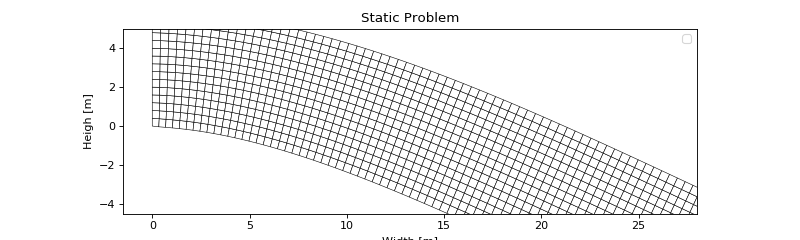

In [7]:
p0=1
fig, ax2 = plt.subplots(1,1,figsize=(10,3))
for i,sysi in enumerate(system_list):
    amfe.plot_2D_system_solution(sysi,u_id=0,ax=ax2,factor=p0)

delta_ = 1.5
ax2.set_xlim([-delta_,(2.0+delta_)*width])
ax2.set_ylim([-delta_*3,(1.0+delta_)*heigh ])
ax2.set_aspect('equal')
ax2.set_xlabel('Width [m]')
ax2.set_ylabel('Heigh [m]')
plt.title('Static Problem')
plt.legend('off')

# Solving Hybrid Eigen-problem

$$
\begin{bmatrix}
\mathbf{K} & \mathbf{B^T}  \\
\mathbf{B} & \mathbf{0}  
\end{bmatrix}
\begin{bmatrix}
\mathbf{u}  \\
\mathbf{\lambda}   
\end{bmatrix}
=
\omega^2
\begin{bmatrix}
\mathbf{M} & \mathbf{0}  \\
\mathbf{0} & \mathbf{0}  
\end{bmatrix}
\begin{bmatrix}
\mathbf{u}  \\
\mathbf{\lambda}   
\end{bmatrix}
$$

In [8]:
M_dict = {}
for i in range(len(mesh_list)):
    M_dict[i+1] = M1
    
#K_dict = {1:K1, 2:K2}
feti_obj1 = SerialFETIsolver(K_dict,B_dict,f_dict,tolerance=1.0e-12)
feti_obj2 = SerialFETIsolver(M_dict,B_dict,f_dict,tolerance=1.0e-12)
manager = feti_obj1.manager 
managerM = feti_obj2.manager
Mi = managerM.local_problem_dict[1].K_local
Mi.key_dict = s.selection_dict
Mi.eliminate_by_identity(1,multiplier=0.0)
for i in range(len(mesh_list)):
    M_dict[i+1] = copy.deepcopy(Mi)

In [9]:
B = manager.assemble_global_B().A
R = manager.assemble_global_kernel().A
M_,_ = managerM.assemble_global_K_and_f()
K, _ = manager.assemble_global_K_and_f()
M = M_.A

B_ = B #np.vstack([B,R.T])
BBT_inv = np.linalg.pinv(B_.dot(B_.T))
scaling = manager.assemble_global_scaling()
S = np.diag(1./scaling)
BBT_inv_tilde = B.dot(S).dot(S.dot(B.T))
BBT_inv_tilde = BBT_inv
P = np.eye(M.shape[0]) - B_.T.dot(BBT_inv_tilde.dot(B_))
u0 = solution_obj.displacement 

# Solving Hybrid Eigen-problem using the Primal Assembly Operator

$$
\begin{bmatrix}
\mathbf{L}^T \mathbf{K} \mathbf{L}^T 
\end{bmatrix}
\begin{bmatrix}
\mathbf{u}  \\
\end{bmatrix}
=
\omega^2
\begin{bmatrix}
\mathbf{L}^T \mathbf{M} \mathbf{L} 
\end{bmatrix}
\begin{bmatrix}
\mathbf{u}  \\
\end{bmatrix}
$$

In [10]:
L = manager.assemble_global_L()
Lexp = manager.assemble_global_L_exp()

Kp = L.dot(K.dot(Lexp))
Mp = L.dot(M.dot(Lexp))
Dp = np.linalg.inv(Kp).dot(Mp)
nmodes = 30
eigval_, Vp = sparse.linalg.eigsh(Dp,k=nmodes,v0=L.dot(u0))
eigval_

val_p = np.sort(1/eigval_)
val_p

freq_p = np.sqrt(val_p)/(2.0*np.pi)
freq_p

array([  4.77822046,  26.37534651,  40.47792026,  63.54358302,
       106.65492122, 121.12931869, 153.71317423, 200.10331609,
       200.55594934, 246.44668422, 276.43061287, 276.76974627,
       296.59237867, 312.8268831 , 343.53825217, 346.53806921,
       362.37603149, 380.9787728 , 388.52674495, 399.34293668,
       413.68051297, 416.57639331, 434.52062704, 435.55974165,
       443.50782519, 449.61442929, 451.46647517, 455.04363576,
       465.08093816, 467.6721622 ])

<IPython.core.display.Javascript object>


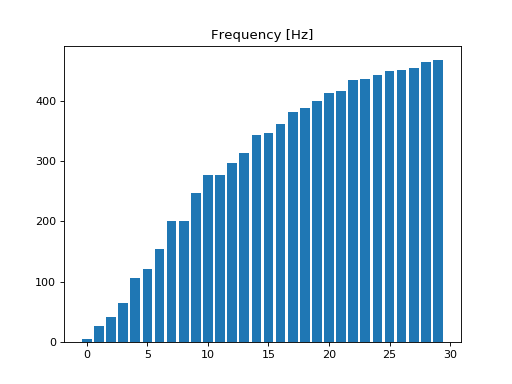

Text(0.5, 1.0, 'Frequency [Hz]')

In [11]:
plt.figure()
plt.bar(list(range(len(freq_p))),freq_p)
plt.title('Frequency [Hz]')

In [12]:
Vprimal = Lexp.dot(Vp)

In [13]:
facecolor_list

[array([0.55632319, 0.55632319, 0.55632319]),
 array([0.83350693, 0.83350693, 0.83350693]),
 array([0.76007719, 0.76007719, 0.76007719]),
 array([0.72274082, 0.72274082, 0.72274082]),
 array([0.54416471, 0.54416471, 0.54416471]),
 array([0.56446735, 0.56446735, 0.56446735]),
 array([0.5302045, 0.5302045, 0.5302045]),
 array([0.57310997, 0.57310997, 0.57310997]),
 array([0.9540913, 0.9540913, 0.9540913]),
 array([0.7364548, 0.7364548, 0.7364548]),
 array([0.93851277, 0.93851277, 0.93851277]),
 array([0.52736475, 0.52736475, 0.52736475])]

In [14]:
v_dict = manager.vector2localdict(Vprimal,manager.global2local_primal_dofs)
for i,sysi in enumerate(system_list):
    vi = v_dict[i+1]
    sysi.u_output = list(vi.T)

<IPython.core.display.Javascript object>


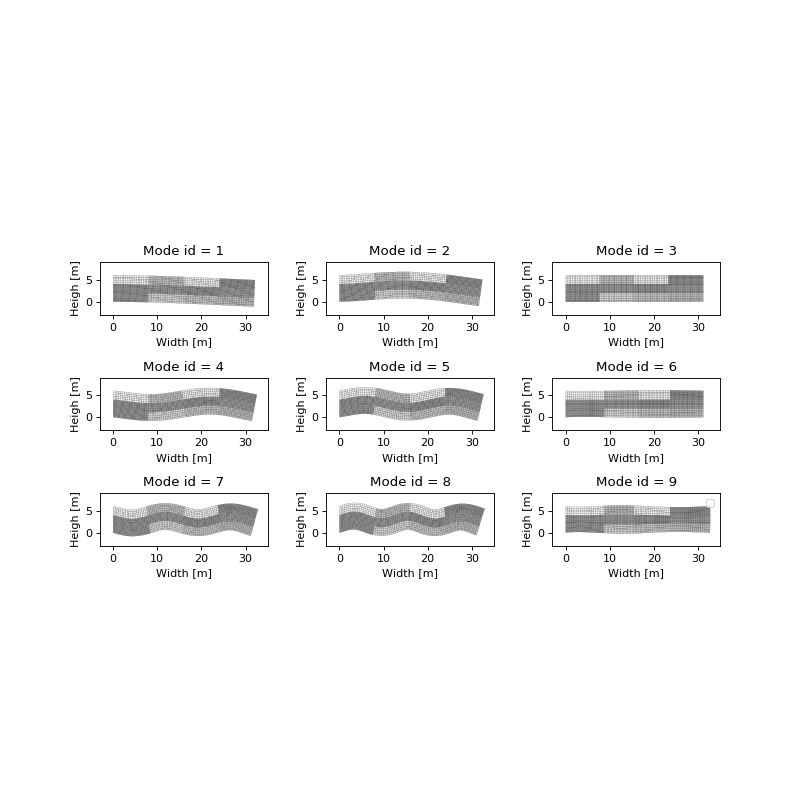

In [15]:
fig, ax3_list = plt.subplots(3,3,figsize=(10,10))
counter = 0
delta_ = 1.0
for ax_ij in ax3_list:
    for ax2 in ax_ij:
        for i,sysi in enumerate(system_list):
            amfe.plot_2D_system_solution(sysi,u_id=(nmodes - 1 - counter),ax=ax2,factor=20,
                        facecolor=tuple(facecolor_list[i]),linewidth=0.1)
    
        delta = 3
        ax2.set_xlim([-delta,domains_X*width+delta])
        ax2.set_ylim([-delta,domains_Y*heigh+delta])
        
        ax2.set_aspect('equal')
        ax2.set_xlabel('Width [m]')
        ax2.set_ylabel('Heigh [m]')
        ax2.set_title('Mode id = %i' %(counter+1) )
        counter+=1
plt.legend('off')
#plt.tight_layout()
plt.subplots_adjust(hspace=-0.70, wspace=0.35)

# Solving Hybrid Eigen-problem using the inverse iteration =

$$
\begin{bmatrix}
\mathbf{K} & \mathbf{B^T}  \\
\mathbf{B} & \mathbf{0}  
\end{bmatrix}
\begin{bmatrix}
\mathbf{u_{n+1}}  \\
\mathbf{\lambda_{n+1}}   
\end{bmatrix}
=
\begin{bmatrix}
\mathbf{M} & \mathbf{0}  \\
\mathbf{0} & \mathbf{0}  
\end{bmatrix}
\begin{bmatrix}
\mathbf{u_{n}}  \\
\mathbf{\lambda_{n}}   
\end{bmatrix}
$$

using initial random guess

In [16]:
countswp=0
def system_without_projection(u,tol=1.0e-8):
    
    global countswp
    f = M.dot(u)
    f_dict = manager.vector2localdict(f,manager.global2local_primal_dofs)
    feti_obj = SerialFETIsolver(K_dict,B_dict,f_dict,tolerance=tol)
    solution_obj = feti_obj.solve()
    u_dict = solution_obj.u_dict
    countswp+=1
    return solution_obj.displacement
    
un = system_without_projection(u0)
D_wp = sparse.linalg.LinearOperator(shape=M.shape,matvec = lambda x : system_without_projection(x))

In [17]:
np.random.seed(1)
u0 = np.random.rand(D_wp.shape[0])
u0 /= np.linalg.norm(u0)

In [18]:
np.linalg.norm(u0)

0.9999999999999999

In [19]:
eigval_without_projection_, V_wp_ = sparse.linalg.eigs(D_wp,k=nmodes,v0=u0,maxiter=200)
val_wp_ = np.sort(1/eigval_without_projection_.real)
freq_dual_wp_ = np.sqrt(val_wp_)/(2.0*np.pi)
freq_dual_wp_

array([  4.77931359,  26.21771043,  40.46359879,  63.31579875,
       106.5300346 , 121.11120487, 152.81786934, 199.37420435,
       200.63173849, 245.29936054, 274.76417556, 276.44639133,
       295.82038169, 313.32920356, 342.40495158, 344.86183105,
       361.4062467 , 380.63391317, 389.76694669, 399.0261583 ,
       416.40182052, 416.40182052, 431.385798  , 433.79615749,
       445.56234575, 450.59967982, 454.15163279, 454.15163279,
       468.39302781, 473.68931386])

In [20]:
countswp

93

<IPython.core.display.Javascript object>


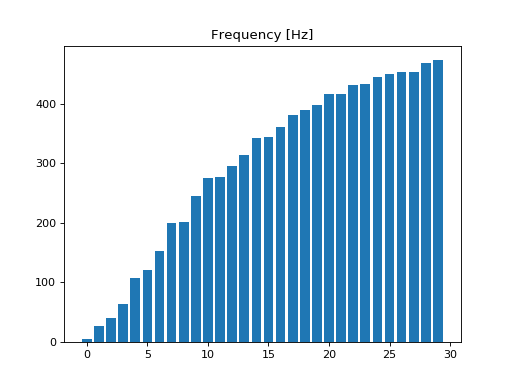

Text(0.5, 1.0, 'Frequency [Hz]')

In [21]:
plt.figure()
plt.bar(list(range(len(freq_dual_wp_))),freq_dual_wp_)
plt.title('Frequency [Hz]')

<IPython.core.display.Javascript object>


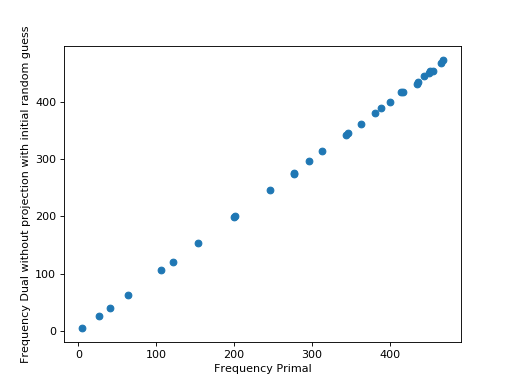

Text(0, 0.5, 'Frequency Dual without projection with initial random guess')

In [22]:
plt.figure()
plt.plot(freq_p,freq_dual_wp_,'o')
plt.xlabel('Frequency Primal')
plt.ylabel('Frequency Dual without projection with initial random guess')

In [23]:
shift=0
#error = 100*np.abs(freq_p[:-shift] - freq_dual_wp_[shift:])/freq_p[:-shift]
error = 100*np.abs(freq_p - freq_dual_wp_)/freq_p
max_error = error.max()
print(max_error)

1.2866174522870382


In [24]:
np.mean(error )

0.35351392530301085

<IPython.core.display.Javascript object>


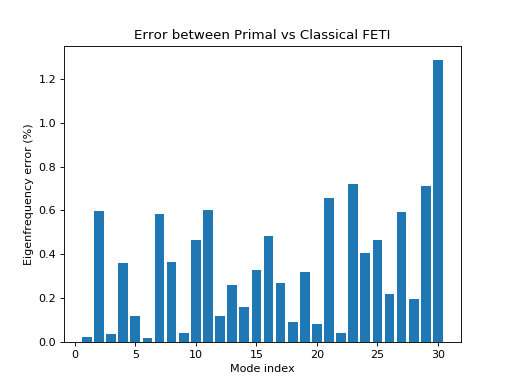

Text(0.5, 1.0, 'Error between Primal vs Classical FETI')

In [25]:
plt.figure()
#plt.plot(error,'o')
plt.bar(list(range(1,len(error)+1)),error)
plt.xlabel('Mode index')
plt.ylabel('Eigenfrequency error (%)')
plt.title('Error between Primal vs Classical FETI')


In [26]:
v_dict = manager.vector2localdict(V_wp_.real,manager.global2local_primal_dofs)
for i,sysi in enumerate(system_list):
    vi = v_dict[i+1]
    sysi.u_output = list(vi.T)


<IPython.core.display.Javascript object>


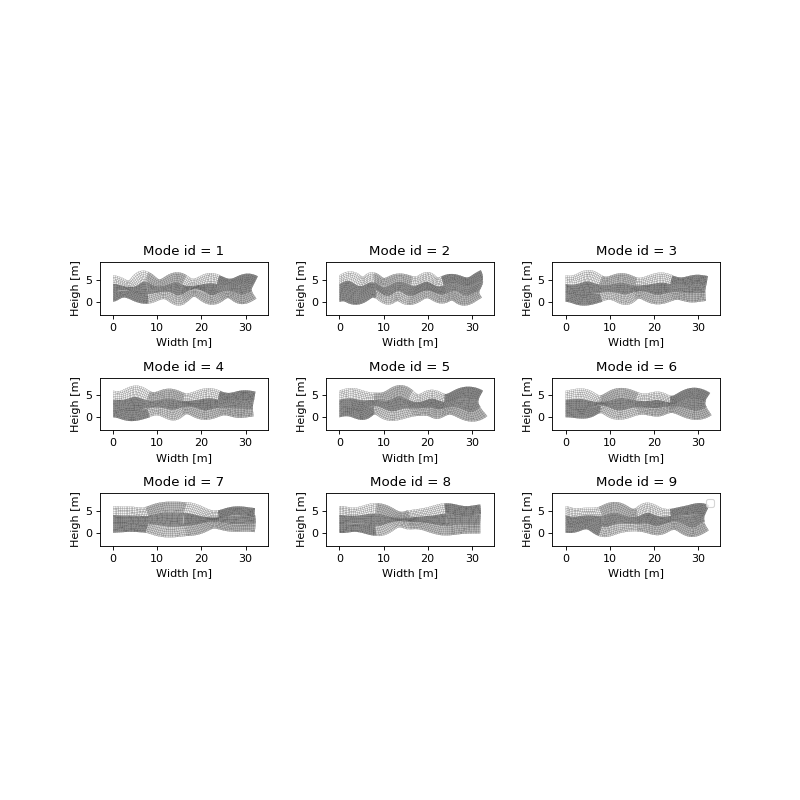

In [27]:
fig, ax1_list = plt.subplots(3,3,figsize=(10,10))
counter = 0
delta_ = 1.0
for ax_ij in ax1_list:
    for ax2 in ax_ij:
        for i,sysi in enumerate(system_list):
            amfe.plot_2D_system_solution(sysi,u_id=(nmodes -1 - counter),ax=ax2,factor=20,
             facecolor=tuple(facecolor_list[i]),linewidth=0.1)
    
        delta = 3
        ax2.set_xlim([-delta,domains_X*width+delta])
        ax2.set_ylim([-delta,domains_Y*heigh+delta])
        
        ax2.set_aspect('equal')
        ax2.set_xlabel('Width [m]')
        ax2.set_ylabel('Heigh [m]')
        ax2.set_title('Mode id = %i' %(counter+1) )
        counter+=1
plt.legend('off')
#plt.tight_layout()
plt.subplots_adjust(hspace=-0.70, wspace=0.35)

# Solving Hybrid Eigen-problem using the inverse iteration =

$$
\begin{bmatrix}
\mathbf{K} & \mathbf{B^T}  \\
\mathbf{B} & \mathbf{0}  
\end{bmatrix}
\begin{bmatrix}
\mathbf{u_{n+1}}  \\
\mathbf{\lambda_{n+1}}   
\end{bmatrix}
=
\begin{bmatrix}
\mathbf{M} & \mathbf{0}  \\
\mathbf{0} & \mathbf{0}  
\end{bmatrix}
\begin{bmatrix}
\mathbf{u_{n}}  \\
\mathbf{\lambda_{n}}   
\end{bmatrix}
$$

using initial guess $v_0 = P v$

In [28]:
eigval_without_projection, V_wp = sparse.linalg.eigs(D_wp,k=nmodes,v0 = P.dot(u0))
val_wp = np.sort(1/eigval_without_projection.real)
freq_dual_wp = np.sqrt(val_wp)/(2.0*np.pi)
freq_dual_wp

array([  4.77931763,  26.21839704,  40.46286162,  63.32815907,
       106.51425677, 121.11847907, 152.75169926, 199.72898882,
       200.64034767, 246.15099931, 275.6286841 , 276.79425496,
       296.20945119, 312.55182387, 342.38197214, 345.34658392,
       361.32497014, 374.81566063, 391.96352164, 398.19078308,
       413.29081917, 417.87765839, 430.01767413, 434.83288079,
       446.7521493 , 450.40708216, 455.56567687, 460.6373977 ,
       464.46474874, 479.41521456])

<IPython.core.display.Javascript object>


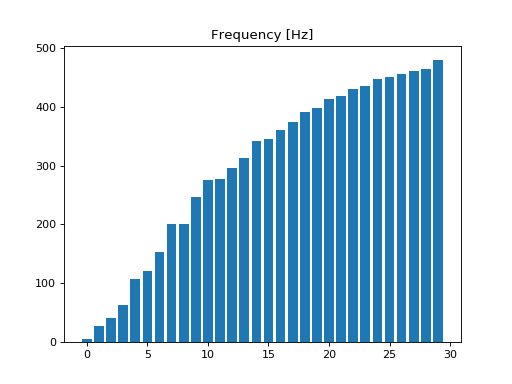

Text(0.5, 1.0, 'Frequency [Hz]')

In [29]:
plt.figure()
plt.bar(list(range(len(freq_dual_wp))),freq_dual_wp)
plt.title('Frequency [Hz]')

<IPython.core.display.Javascript object>


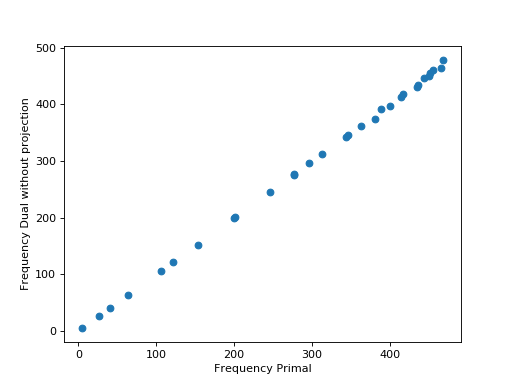

Text(0, 0.5, 'Frequency Dual without projection')

In [30]:
plt.figure()
plt.plot(freq_p,freq_dual_wp,'o')
plt.xlabel('Frequency Primal')
plt.ylabel('Frequency Dual without projection')

In [31]:
error = 100*np.abs(freq_p - freq_dual_wp)/freq_p
max_error = error.max()
print(max_error)

2.510958169289697


In [32]:
np.mean(error )

0.4561735299570838

<IPython.core.display.Javascript object>


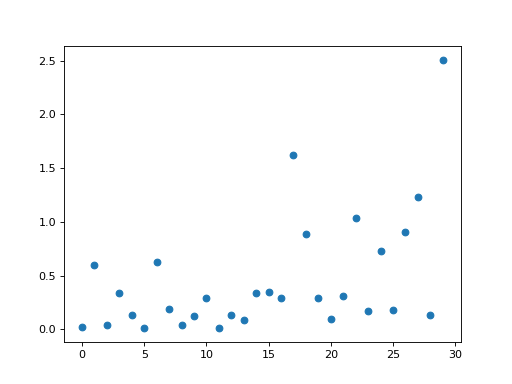

In [33]:
plt.figure()
plt.plot(error,'o')

In [34]:
v_dict = manager.vector2localdict(V_wp,manager.global2local_primal_dofs)
for i,sysi in enumerate(system_list):
    vi = v_dict[i+1]
    sysi.u_output = list(vi.T)

<IPython.core.display.Javascript object>


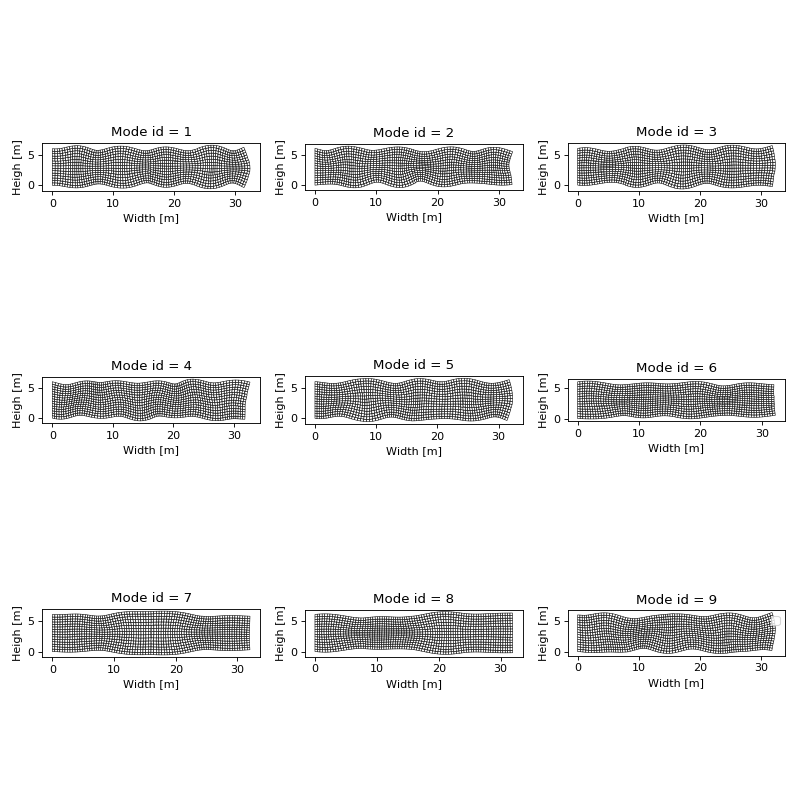

In [35]:
fig, ax1_list = plt.subplots(3,3,figsize=(10,10))
counter = 0
delta_ = 1.0
for ax_ij in ax1_list:
    for ax2 in ax_ij:
        for i,sysi in enumerate(system_list):
            amfe.plot_2D_system_solution(sysi,u_id=(nmodes - 1 - counter),ax=ax2,factor=10)
        #ax2.set_xlim([-delta_*width,(2.0+delta_)*width])
        #ax2.set_ylim([-delta_*heigh,(1.0+delta_)*heigh ])
        ax2.set_aspect('equal')
        ax2.set_xlabel('Width [m]')
        ax2.set_ylabel('Heigh [m]')
        ax2.set_title('Mode id = %i' %(counter+1) )
        counter+=1
plt.legend('off')
plt.tight_layout()

# Solving Hybrid Eigen-problem using the inverse iteration =

$$
\begin{bmatrix}
\mathbf{K} & \mathbf{B^T}  \\
\mathbf{B} & \mathbf{0}  
\end{bmatrix}
\begin{bmatrix}
\mathbf{u_{n+1}}  \\
\mathbf{\lambda_{n+1}}   
\end{bmatrix}
=
\begin{bmatrix}
\mathbf{P}^T \mathbf{M}\mathbf{P} & \mathbf{0}  \\
\mathbf{0} & \mathbf{0}  
\end{bmatrix}
\begin{bmatrix}
\mathbf{u_{n}}  \\
\mathbf{\lambda_{n}}   
\end{bmatrix}
$$

using initial guess $v_0 = P v$

In [36]:
#u0 = solution_obj.displacement 
counts=0
def system(u,tol=1.0e-8):
    global counts
    f = P.T.dot(M.dot(P.dot(u)))
    f_dict = manager.vector2localdict(f,manager.global2local_primal_dofs)
    feti_obj = SerialFETIsolver(K_dict,B_dict,f_dict,tolerance=tol)
    solution_obj = feti_obj.solve()
    u_dict = solution_obj.u_dict
    counts+=1
    return solution_obj.displacement
    
un = system(u0)
un1 = system_without_projection(u0)



<IPython.core.display.Javascript object>


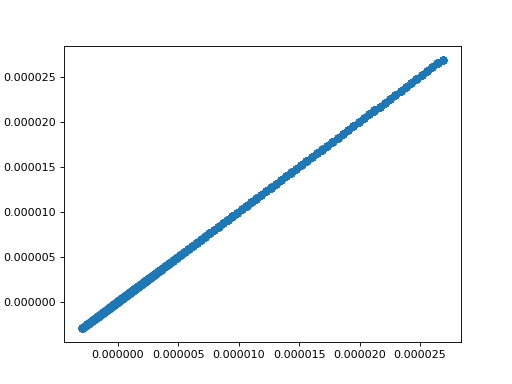

In [37]:
plt.figure()
plt.plot(un,un1,'o')

In [38]:
D = sparse.linalg.LinearOperator(shape=M.shape,matvec = lambda x : system(x))
eigval, V = sparse.linalg.eigs(D,k=nmodes,v0 = P.dot(u0))
val = np.sort(1/eigval.real)
freq_dual = np.sqrt(val)/(2.0*np.pi)
freq_dual

array([  4.77931204,  26.21775389,  40.46393074,  63.31572441,
       106.52658371, 121.1165632 , 152.80246452, 199.74176575,
       200.66104602, 245.88974865, 275.12419569, 276.47907934,
       296.00442551, 312.04759826, 344.48118594, 344.6324086 ,
       362.67310696, 375.95556991, 387.55274049, 397.71033005,
       417.52302598, 417.52302598, 430.74129371, 435.37686372,
       443.04303235, 447.05996136, 454.23086866, 454.23086866,
       469.38786278, 483.07163902])

In [39]:
counts

107

In [40]:
up = P.dot(u0)

In [41]:
B.dot(up)

array([-3.46944695e-18, -3.46944695e-18, -3.46944695e-18, -1.73472348e-18,
       -3.46944695e-18,  0.00000000e+00,  5.20417043e-18, -1.73472348e-18,
       -6.93889390e-18, -6.93889390e-18, -1.04083409e-17,  6.93889390e-18,
        5.20417043e-18, -1.38777878e-17,  1.21430643e-17,  1.56125113e-17,
        1.73472348e-17, -6.93889390e-18,  6.07153217e-18,  6.93889390e-18,
       -4.16333634e-17, -1.99493200e-17,  1.08420217e-17, -2.94902991e-17,
       -2.60208521e-17,  2.77555756e-17,  6.93889390e-18,  0.00000000e+00,
       -3.46944695e-18, -1.90819582e-17, -1.38777878e-17,  1.73472348e-17,
        0.00000000e+00,  3.46944695e-18, -6.93889390e-18,  6.93889390e-18,
        2.08166817e-17,  1.73472348e-17,  3.12250226e-17,  8.67361738e-18,
       -1.56125113e-17,  3.46944695e-18, -2.08166817e-17, -2.08166817e-17,
       -2.77555756e-17,  2.42861287e-17,  2.08166817e-17,  1.38777878e-17,
        6.93889390e-18,  6.93889390e-18,  3.46944695e-18,  6.93889390e-18,
        1.73472348e-18, -

<IPython.core.display.Javascript object>


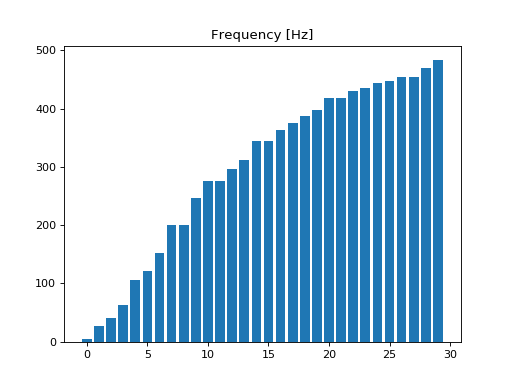

Text(0.5, 1.0, 'Frequency [Hz]')

In [42]:
plt.figure()
plt.bar(list(range(len(freq_dual))),freq_dual)
plt.title('Frequency [Hz]')

<IPython.core.display.Javascript object>


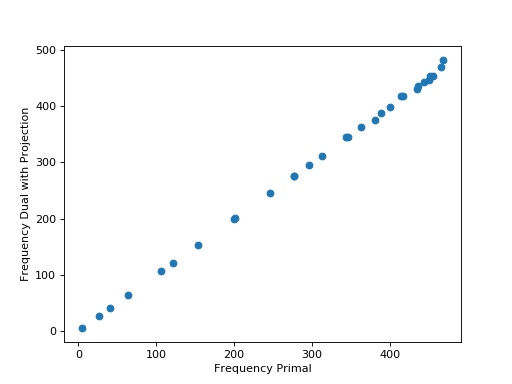

Text(0, 0.5, 'Frequency Dual with Projection')

In [43]:
plt.figure()
plt.plot(freq_p,freq_dual,'o')
plt.xlabel('Frequency Primal')
plt.ylabel('Frequency Dual with Projection')

In [44]:
error = 100*np.abs(freq_p - freq_dual)/freq_p
max_error = error.max()
print(max_error)

3.2927931287479604


In [45]:
np.mean(error )

0.4618611706039729

<IPython.core.display.Javascript object>


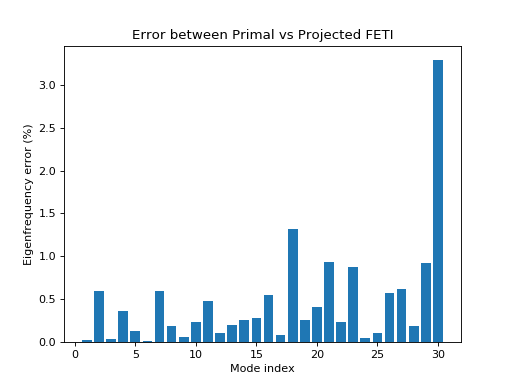

Text(0.5, 1.0, 'Error between Primal vs Projected FETI')

In [46]:
plt.figure()
#plt.plot(error,'o')
plt.bar(list(range(1,len(error)+1)),error)
plt.xlabel('Mode index')
plt.ylabel('Eigenfrequency error (%)')
plt.title('Error between Primal vs Projected FETI')

In [47]:
v_dict = manager.vector2localdict(V,manager.global2local_primal_dofs)
for i,sysi in enumerate(system_list):
    vi = v_dict[i+1]
    sysi.u_output = list(vi.T)

<IPython.core.display.Javascript object>


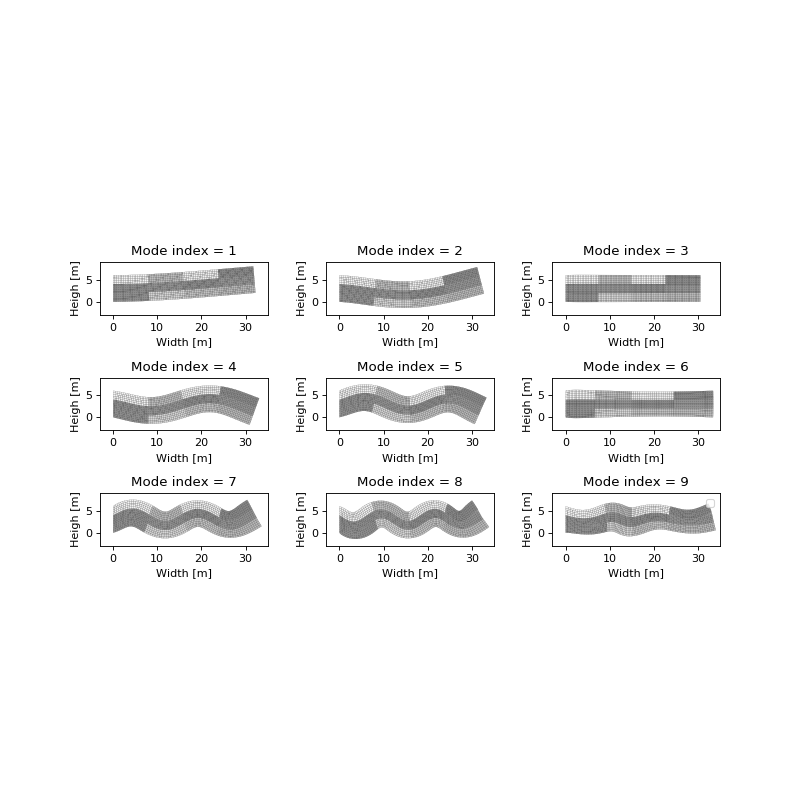

In [48]:
fig, ax3_list = plt.subplots(3,3,figsize=(10,10))
counter = 0
delta_ = 1.0
for ax_ij in ax3_list:
    for ax2 in ax_ij:
        for i,sysi in enumerate(system_list):
            amfe.plot_2D_system_solution(sysi,u_id=(nmodes - 1 - counter),ax=ax2,factor=40,
                                         facecolor=tuple(facecolor_list[i]),linewidth=0.1)
        #ax2.set_xlim([-delta_*width,(2.0+delta_)*width])
        #ax2.set_ylim([-delta_*heigh,(1.0+delta_)*heigh ])
        delta = 3
        ax2.set_xlim([-delta,domains_X*width+delta])
        ax2.set_ylim([-delta,domains_Y*heigh+delta])
        #ax2.set_ylim([-2,domains_X*width+2])
        
        ax2.set_aspect('equal')
        ax2.set_xlabel('Width [m]')
        ax2.set_ylabel('Heigh [m]')
        ax2.set_title('Mode index = %i' %(counter+1) )
        counter+=1
plt.legend('off')
#plt.tight_layout()
plt.subplots_adjust(hspace=-0.70, wspace=0.35)

In [49]:
#fig.savefig('projected_dual_modes_v1.png',dpi=1000)

<IPython.core.display.Javascript object>


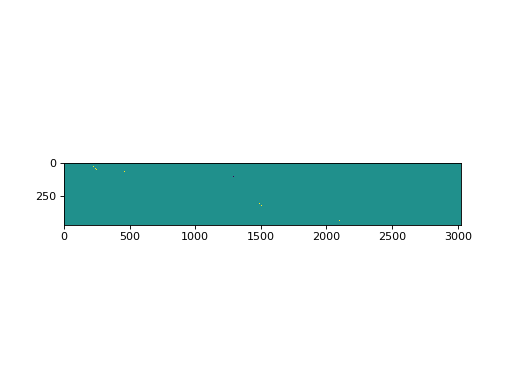

In [50]:
plt.figure()
plt.imshow(B)

<IPython.core.display.Javascript object>


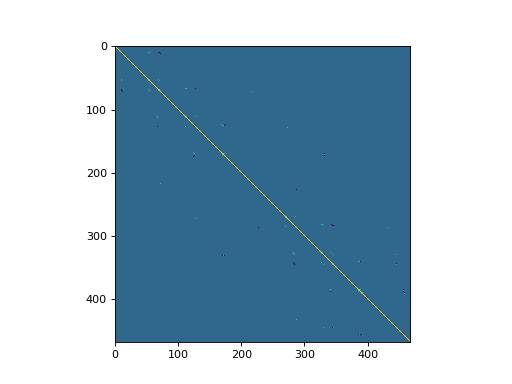

In [51]:
plt.figure()
plt.imshow(B.dot(B.T))

In [52]:
np.diag(B.dot(B.T))

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [53]:
l = [np.array([1,1]),np.array([1,1])]

In [54]:
np.concatenate(l)

array([1, 1, 1, 1])

In [55]:
scaling = manager.assemble_global_scaling()

<IPython.core.display.Javascript object>


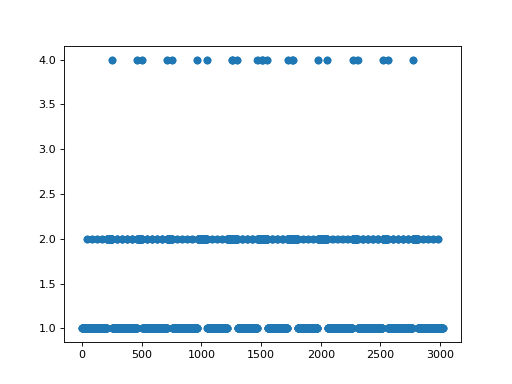

In [56]:
plt.figure(0)
plt.plot(scaling,'o')

/home/ge72tih/miniconda3/lib/python3.7/site-packages/matplotlib-3.0.3-py3.7-linux-x86_64.egg/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


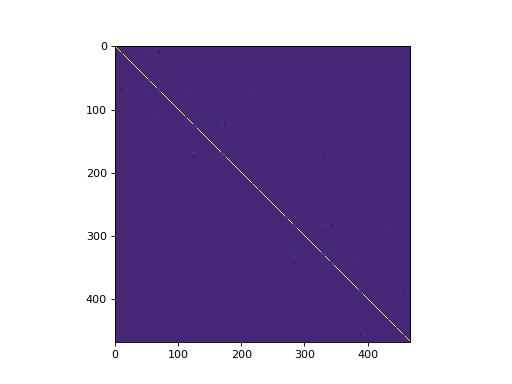

In [57]:
plt.figure()
plt.imshow(BBT_inv)

In [58]:
BBT_inv

array([[0.5, 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0.5, 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0.5, ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0.5, 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0.5, 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0.5]])

In [59]:
S = np.diag(1./scaling)
S*B.T.dot(B)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

<IPython.core.display.Javascript object>


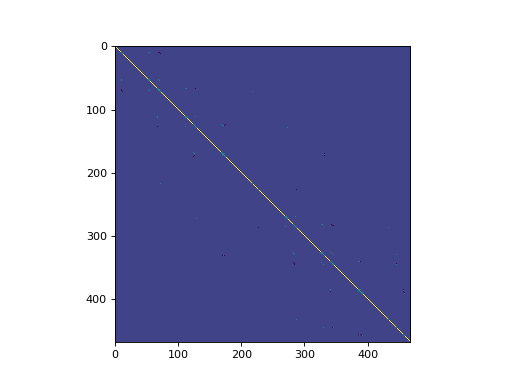

In [60]:
plt.figure()
plt.imshow(B.dot(S.dot(B.T)))

In [61]:
BB_inv_tilde = B.dot(S).dot(S.dot(B.T))

<IPython.core.display.Javascript object>


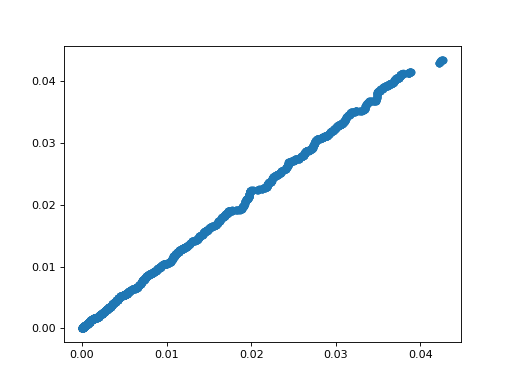

In [62]:
mode_id = 3
plt.figure()
plt.plot(np.sort(np.abs(V[:,nmodes-mode_id-1].real)),np.sort(np.abs(Vprimal[:,nmodes-mode_id-1])),'o')

<IPython.core.display.Javascript object>


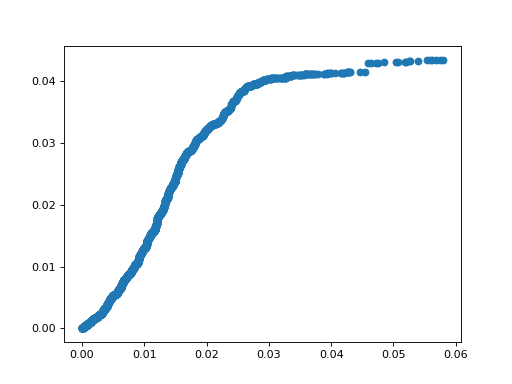

In [63]:
#mode_id = 0
plt.figure()
plt.plot(np.sort(np.abs(V_wp_[:,nmodes-mode_id-1].real)),np.sort(np.abs(Vprimal[:,nmodes-mode_id-1])),'o')

In [64]:
error = BB_inv_tilde - BBT_inv

In [65]:
error.max()

1.503722669655968e-15

In [66]:
error.min()

-2.165221336920759e-15

In [68]:
V_wp_.real

array([[ 3.49217573e-19,  2.59143165e-18,  1.79673273e-18, ...,
        -8.23494813e-18, -1.75546691e-17,  3.83822376e-17],
       [-1.70069113e-18,  7.75169244e-18, -1.14055667e-17, ...,
        -6.86217392e-18, -2.12696024e-17, -8.55967923e-18],
       [-2.31600182e-04, -1.22753846e-03,  9.55637263e-04, ...,
        -3.72285741e-03, -3.66722320e-03,  4.43453281e-03],
       ...,
       [-4.97340488e-02,  4.36787169e-02,  4.00841420e-05, ...,
        -6.32376953e-03,  4.71508147e-02, -1.81032137e-03],
       [ 6.34821439e-03, -1.95497424e-02,  3.62811385e-02, ...,
         1.20320239e-02,  2.81316052e-03,  3.89030998e-02],
       [-5.05814769e-02,  4.63150638e-02,  8.03661910e-05, ...,
        -1.00289806e-02,  5.71402240e-02, -1.13892267e-02]])

In [69]:
V.real

array([[ 9.85720101e-17,  7.09206577e-17, -2.83361303e-18, ...,
         3.23792295e-18, -4.74726623e-18, -2.53439052e-18],
       [ 9.88042268e-17,  1.10736144e-16,  7.46915846e-19, ...,
         3.01025550e-18, -9.00287285e-18, -5.24150095e-18],
       [-8.51675781e-03,  8.67045275e-03,  9.30966494e-04, ...,
        -9.55176212e-04, -1.22764692e-03,  2.31600085e-04],
       ...,
       [ 4.79470070e-03, -3.96904051e-02,  5.16249436e-03, ...,
        -3.98457990e-05,  4.36779161e-02,  4.97340546e-02],
       [ 5.01827612e-02, -1.19613735e-02, -8.02428250e-03, ...,
        -3.62813771e-02, -1.95491723e-02, -6.34821755e-03],
       [-6.13035697e-03, -4.54634588e-02,  7.35298218e-03, ...,
        -7.98744702e-05,  4.63140652e-02,  5.05814829e-02]])

In [ ]:
freq_